This notebook is based on notebook 1, but trying to handle the difference of the aspect ratio on the training data of the normal pictures.
Following adaptations were added/tested:
- Added to the preprocessing of the images: Resize with padding function, to keep the aspect ratio (h/w)

In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import os
from PIL import Image
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dropout, MaxPooling2D, Flatten, Dense, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.callbacks import Callback, EarlyStopping
from tensorflow.keras.metrics import Precision, Recall, AUC
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import shap
from datetime import datetime
start_time = datetime.now()
print(os.listdir("input"))
tf.random.set_seed(11)
np.random.seed(11)
import random
random.seed(11)
os.environ['TF_DETERMINISTIC_OPS'] = '1'
tf.config.experimental.enable_op_determinism()

['chest_xray']


In [2]:
#defining folder parameters #print(mainDIR)
mainDIR = os.listdir('input/chest_xray/chest_xray')
train_folder= 'input/chest_xray/chest_xray/train/'
val_folder = 'input/chest_xray/chest_xray/val/'
test_folder = 'input/chest_xray/chest_xray/test/'
train_n = train_folder+'NORMAL/'
train_p = train_folder+'PNEUMONIA/'
val_n = val_folder+'NORMAL/'
val_p = val_folder+'PNEUMONIA/'
test_n = test_folder+'NORMAL/'
test_p = test_folder+'PNEUMONIA/'

print("nbr of normal pictures in trainingset: " + str(len(os.listdir(train_n))))
print("nbr of sick pictures in trainingset: " + str(len(os.listdir(train_p))))
print("nbr of normal pictures in testset: " + str(len(os.listdir(test_n))))
print("nbr of sick pictures in testset: " + str(len(os.listdir(test_p))))
print("nbr of normal pictures in validationset: " + str(len(os.listdir(val_n))))
print("nbr of sick pictures in validationset: " + str(len(os.listdir(val_p))))

nbr of normal pictures in trainingset: 1342
nbr of sick pictures in trainingset: 3876
nbr of normal pictures in testset: 234
nbr of sick pictures in testset: 390
nbr of normal pictures in validationset: 9
nbr of sick pictures in validationset: 9


random normal picture :  NORMAL2-IM-1096-0001.jpeg
random sick picture : person1504_virus_2614.jpeg
Normal Image Size: (1580, 1329)
Pneumonia Image Size: (1088, 776)
Image Mode normal image: L
Image Mode sick image: L


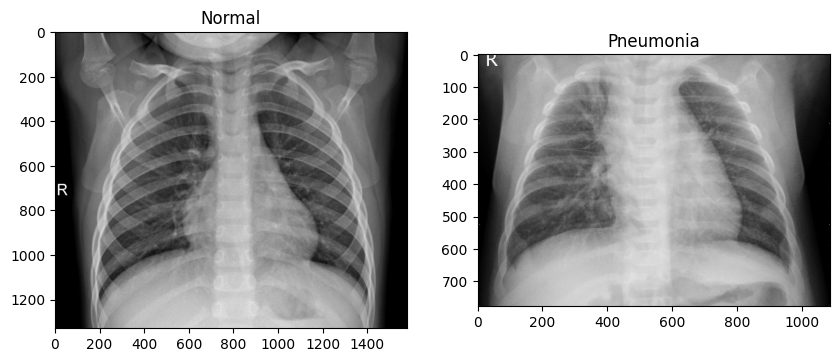

In [3]:
# analysing random training data #
# Normal pic 
rand_norm= np.random.randint(0,len(os.listdir(train_n)))
norm_pic = os.listdir(train_n)[rand_norm]
print('random normal picture : ',norm_pic)
norm_pic_address = train_n+norm_pic
norm_load = Image.open(norm_pic_address)
f = plt.figure(figsize= (10,6))
a1 = f.add_subplot(1,2,1)
img_plot = plt.imshow(norm_load, cmap='gray')
a1.set_title('Normal')
#Pneumonia 
rand_p = np.random.randint(0,len(os.listdir(train_p)))
sic_pic =  os.listdir(train_p)[rand_norm]
sic_address = train_p+sic_pic
print('random sick picture :', sic_pic)
sic_load = Image.open(sic_address)
a2 = f.add_subplot(1, 2, 2)
img_plot = plt.imshow(sic_load, cmap='gray')
a2.set_title('Pneumonia');
# Size
print("Normal Image Size:", norm_load.size)  # Output (width, height)
print("Pneumonia Image Size:", sic_load.size)
# Get mode (color format) # L is one channel
print("Image Mode normal image:", norm_load.mode) 
print("Image Mode sick image:", sic_load.mode)

In [4]:
folder_path =(train_n, train_p, val_n, val_p, test_n, test_p)
widths = []
heights = []
for i in folder_path:
    for filename in os.listdir(i):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):  # Check for image files
            img_path = os.path.join(i, filename)
            with Image.open(img_path) as img:
                width, height = img.size  # Get image size
                widths.append(width)
                heights.append(height)
    avg_width = np.mean(widths)
    avg_height = np.mean(heights)
    print(f"Average Image Size in {i}: {avg_width:.2f} x {avg_height:.2f} pixels (Aspect Ratio: {avg_width/avg_height:.2f})")

Average Image Size in input/chest_xray/chest_xray/train/NORMAL/: 1667.73 x 1381.43 pixels (Aspect Ratio: 1.21)
Average Image Size in input/chest_xray/chest_xray/train/PNEUMONIA/: 1320.61 x 968.07 pixels (Aspect Ratio: 1.36)
Average Image Size in input/chest_xray/chest_xray/val/NORMAL/: 1320.85 x 968.42 pixels (Aspect Ratio: 1.36)
Average Image Size in input/chest_xray/chest_xray/val/PNEUMONIA/: 1320.70 x 968.18 pixels (Aspect Ratio: 1.36)
Average Image Size in input/chest_xray/chest_xray/test/NORMAL/: 1341.23 x 985.34 pixels (Aspect Ratio: 1.36)
Average Image Size in input/chest_xray/chest_xray/test/PNEUMONIA/: 1327.88 x 970.69 pixels (Aspect Ratio: 1.37)


In [5]:
#mageDataGenerator augments your image by iterating through image
# Resize with padding function (compatible with ImageDataGenerator)
def preprocess_with_resize(image):
    image = tf.image.resize_with_pad(image,64,64)  # Apply resizing
    return image

train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=1,
    zoom_range=0.2,
    horizontal_flip=False,
    preprocessing_function=preprocess_with_resize  # Apply resize
)

training_set = train_datagen.flow_from_directory(train_folder,
                                                 target_size = (64,64),
                                                 batch_size = 32,
                                                 color_mode='grayscale',
                                                 shuffle=True,
                                                 seed=11,
                                                 class_mode = 'binary')

rescaled_set = ImageDataGenerator(rescale = 1./255, preprocessing_function=preprocess_with_resize)

validation_generator = rescaled_set.flow_from_directory(val_folder,
    target_size=(64,64),
    batch_size=32,
    color_mode='grayscale',
    class_mode='binary')

test_set = rescaled_set.flow_from_directory(test_folder,
                                            target_size = (64,64),
                                            batch_size = 32,
                                            color_mode='grayscale',
                                            class_mode = 'binary',
                                            shuffle=False)  # Ensure consistency

print(validation_generator.class_indices)
print(training_set.class_indices)
print(test_set.class_indices)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
{'NORMAL': 0, 'PNEUMONIA': 1}
{'NORMAL': 0, 'PNEUMONIA': 1}
{'NORMAL': 0, 'PNEUMONIA': 1}


In [6]:
input_shape = (64,64, 1)  
cnn = Sequential()
cnn.add(Input(shape = input_shape))
cnn.add(Conv2D(32, (3, 3), activation="relu"))
cnn.add(MaxPooling2D(pool_size = (2, 2)))
cnn.add(Conv2D(32, (3, 3), activation="relu"))
cnn.add(MaxPooling2D(pool_size = (2, 2)))
cnn.add(Flatten())
cnn.add(Dropout(0.2))
#cnn.add(Dense(activation = 'relu', units = 128))
cnn.add(Dense(activation = 'sigmoid', units = 1))
cnn.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy', Precision(), Recall(), AUC()])
cnn.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 62, 62, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 29, 29, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         6,273 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,841 (61.88 KB)

 Trainable params: 15,841 (61.88 KB)

 Non-trainable params: 0 (0.00 B)

In [7]:
# Define early stopping
early_stop = EarlyStopping(
    monitor='val_loss',  # Stop when validation loss stops improving --- 'val_auc'
    patience=5,  # Number of epochs to wait before stopping
    restore_best_weights=True  # Restore the best model weights
)
# Train the model with early stopping
cnn_model = cnn.fit(
    training_set,
    epochs=50,  # Set a high number, but training will stop early if needed
    validation_data=validation_generator,
    callbacks=[early_stop]  # Attach early stopping
)

c:\repos\Computer_vision\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 30s 178ms/step - accuracy: 0.7386 - auc: 0.6525 - loss: 0.5348 - precision: 0.7525 - recall: 0.9565 - val_accuracy: 0.8125 - val_auc: 0.8906 - val_loss: 0.5100 - val_precision: 0.7273 - val_recall: 1.0000
Epoch 2/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 32s 196ms/step - accuracy: 0.8889 - auc: 0.9450 - loss: 0.2575 - precision: 0.9099 - recall: 0.9445 - val_accuracy: 0.7500 - val_auc: 0.8828 - val_loss: 0.5633 - val_precision: 0.6667 - val_recall: 1.0000
Epoch 3/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 32s 195ms/step - accuracy: 0.9054 - auc: 0.9542 - loss: 0.2332 - precision: 0.9260 - recall: 0.9492 - val_accuracy: 0.6875 - val_auc: 0.8984 - val_loss: 0.5808 - val_precision: 0.6154 - val_recall: 1.0000
Epoch 4/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 30s 187ms/step - accuracy: 0.9117 - auc: 0.9633 - loss: 0.2154 - precision: 0.9367 - recall: 0.9452 - val_accuracy: 0.8750 - val_auc: 0.9453 - val_loss: 0.3978 - val_precision: 0.8000 - val_recall: 1.0000
Epoch 5/50
163/163 ━

In [8]:
print(cnn_model.history.keys())

dict_keys(['accuracy', 'auc', 'loss', 'precision', 'recall', 'val_accuracy', 'val_auc', 'val_loss', 'val_precision', 'val_recall'])


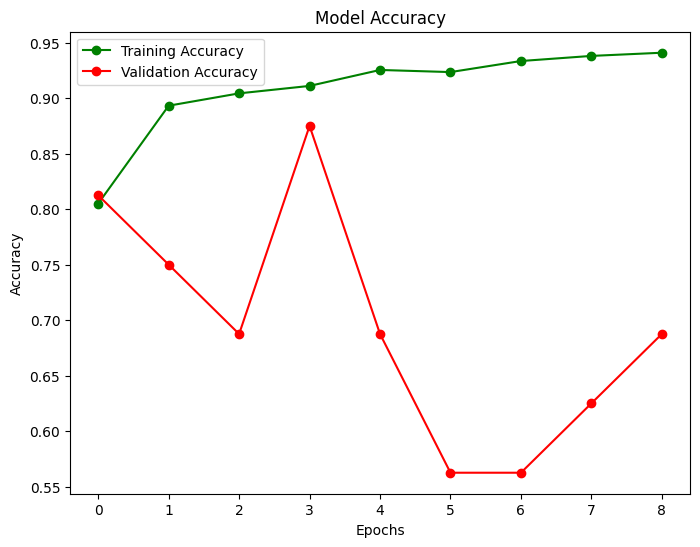

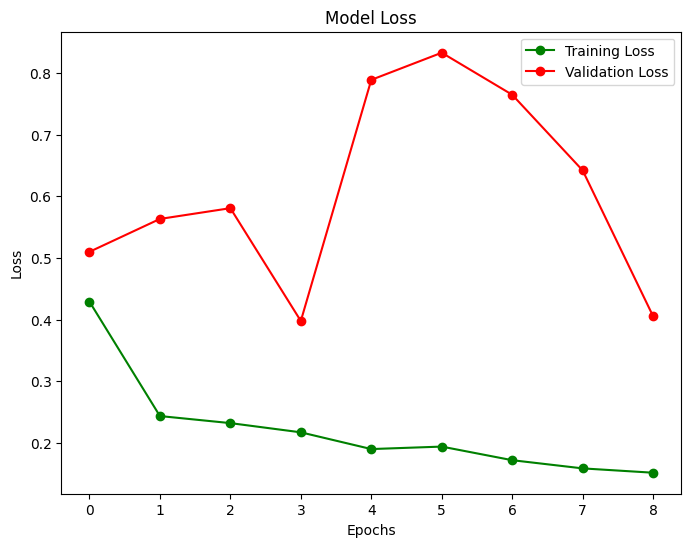

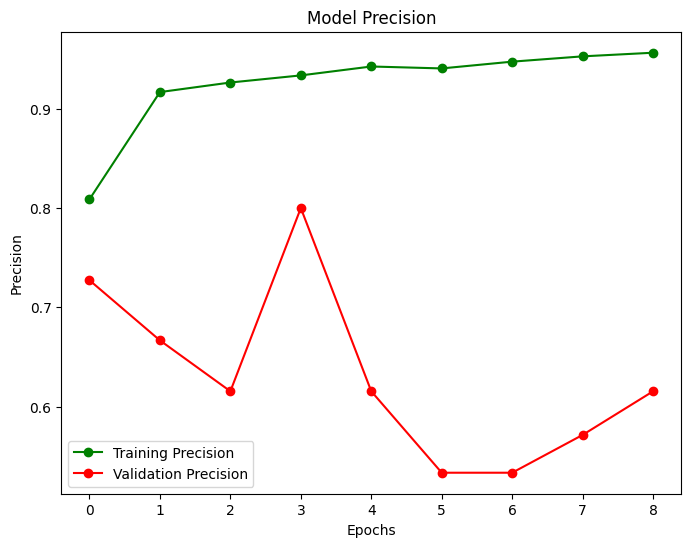

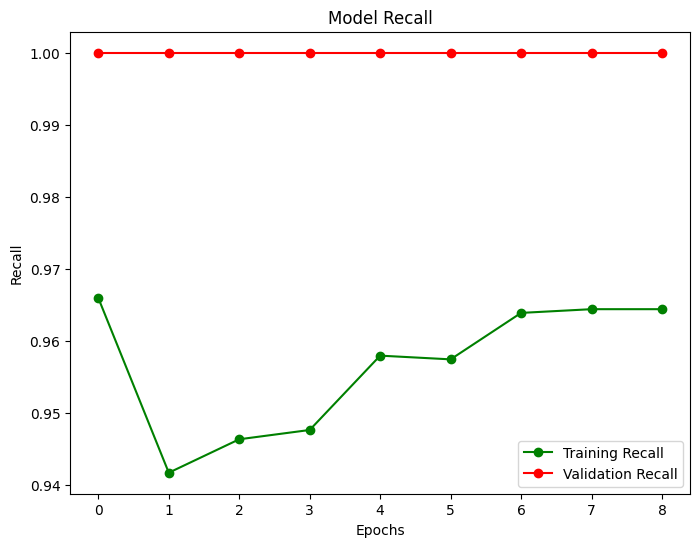

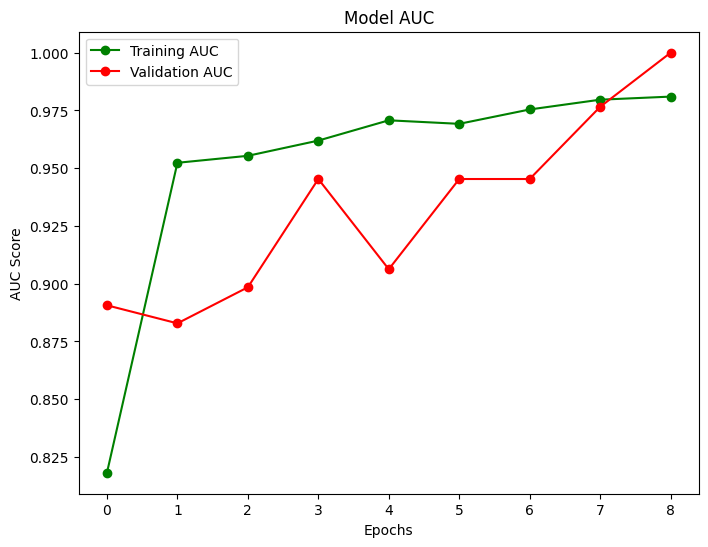

In [9]:
# Plot Accuracy
plt.figure(figsize=(8,6))
plt.plot(cnn_model.history['accuracy'], 'go-', label='Training Accuracy')
plt.plot(cnn_model.history['val_accuracy'], 'ro-', label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
# Plot Loss
plt.figure(figsize=(8,6))
plt.plot(cnn_model.history['loss'], 'go-', label='Training Loss')
plt.plot(cnn_model.history['val_loss'], 'ro-', label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
# Plot Precision
plt.figure(figsize=(8,6))
plt.plot(cnn_model.history['precision'], 'go-', label='Training Precision')
plt.plot(cnn_model.history['val_precision'], 'ro-', label='Validation Precision')
plt.title('Model Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()
plt.show()
# Plot Recall
plt.figure(figsize=(8,6))
plt.plot(cnn_model.history['recall'], 'go-', label='Training Recall')
plt.plot(cnn_model.history['val_recall'], 'ro-', label='Validation Recall')
plt.title('Model Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()
plt.show()
# Plot AUC
plt.figure(figsize=(8,6))
plt.plot(cnn_model.history['auc'], 'go-', label='Training AUC')
plt.plot(cnn_model.history['val_auc'], 'ro-', label='Validation AUC')
plt.title('Model AUC')
plt.xlabel('Epochs')
plt.ylabel('AUC Score')
plt.legend()
plt.show()

In [10]:
loss, accuracy, precision, recall, auc = cnn.evaluate(test_set)
print(f"Test Loss: {loss:.2f}")
print(f"Test Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"AUC: {auc:.2f}")

20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 141ms/step - accuracy: 0.8432 - auc: 0.6436 - loss: 0.3633 - precision: 0.4903 - recall: 0.6479
Test Loss: 0.28
Test Accuracy: 0.89
Precision: 0.87
Recall: 0.96
AUC: 0.96


In [11]:
# Get predicted labels
prediction = cnn.predict(test_set)  # Predict on test set
np.set_printoptions(suppress=True)  # Set print options to suppress scientific notation
prediction

20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 139ms/step


array([[0.09815219],
       [0.1585471 ],
       [0.5074043 ],
       [0.18272363],
       [0.20814428],
       [0.06334689],
       [0.14455462],
       [0.2010843 ],
       [0.5405308 ],
       [0.1542669 ],
       [0.2935929 ],
       [0.66070235],
       [0.20774114],
       [0.06304958],
       [0.23995617],
       [0.038449  ],
       [0.8057792 ],
       [0.31599084],
       [0.032009  ],
       [0.10298745],
       [0.35993314],
       [0.04141008],
       [0.4338841 ],
       [0.05909963],
       [0.4664622 ],
       [0.20561908],
       [0.2585968 ],
       [0.18566407],
       [0.07406552],
       [0.30303714],
       [0.22915219],
       [0.53104365],
       [0.13224804],
       [0.11534871],
       [0.21463823],
       [0.04854243],
       [0.00851158],
       [0.36088225],
       [0.07154457],
       [0.0689887 ],
       [0.46647188],
       [0.07192626],
       [0.08993652],
       [0.01217804],
       [0.11757463],
       [0.256815  ],
       [0.47004858],
       [0.167

20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 139ms/step
Confusion Matrix:
 [[179  55]
 [ 15 375]]


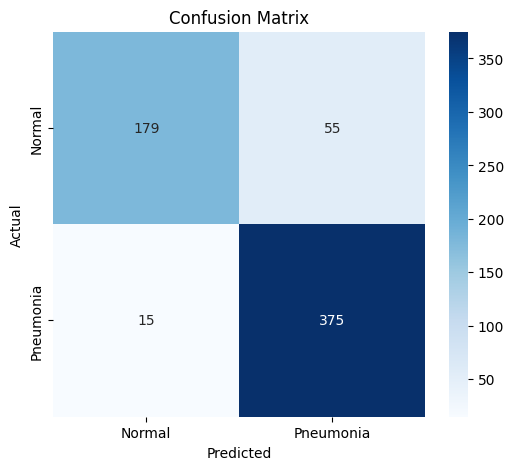

In [12]:
# Compute confusion matrix
y_true = test_set.classes

# Compute confusion matrix using evaluate()
y_pred_eval = (cnn.predict(test_set) > 0.5).astype(int).flatten()
cm = confusion_matrix(y_true, y_pred_eval)

print("Confusion Matrix:\n", cm)

# Plot confusion matrix
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Pneumonia'], yticklabels=['Normal', 'Pneumonia'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [13]:
print(classification_report(y_true, y_pred_eval, target_names=['Normal', 'Pneumonia']))

              precision    recall  f1-score   support

      Normal       0.92      0.76      0.84       234
   Pneumonia       0.87      0.96      0.91       390

    accuracy                           0.89       624
   macro avg       0.90      0.86      0.88       624
weighted avg       0.89      0.89      0.89       624



20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 138ms/step
Confusion Matrix:
 [[158  76]
 [ 10 380]]


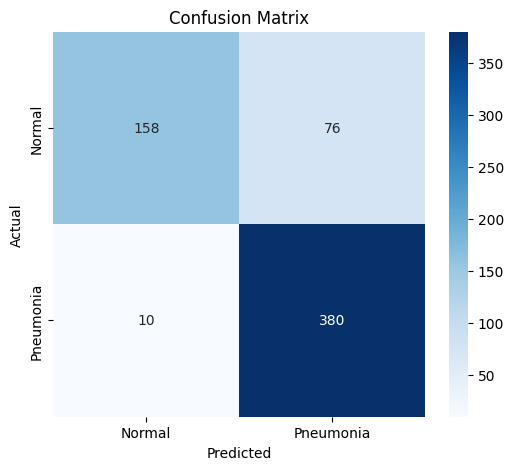

              precision    recall  f1-score   support

      Normal       0.94      0.68      0.79       234
   Pneumonia       0.83      0.97      0.90       390

    accuracy                           0.86       624
   macro avg       0.89      0.82      0.84       624
weighted avg       0.87      0.86      0.86       624



In [14]:
# Compute confusion matrix
y_true = test_set.classes

# Compute confusion matrix using evaluate()
y_pred_eval = (cnn.predict(test_set) > 0.4).astype(int).flatten()
cm = confusion_matrix(y_true, y_pred_eval)

print("Confusion Matrix:\n", cm)

# Plot confusion matrix
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Pneumonia'], yticklabels=['Normal', 'Pneumonia'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

print(classification_report(y_true, y_pred_eval, target_names=['Normal', 'Pneumonia']))

20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 142ms/step
Confusion Matrix:
 [[ 70 164]
 [  0 390]]


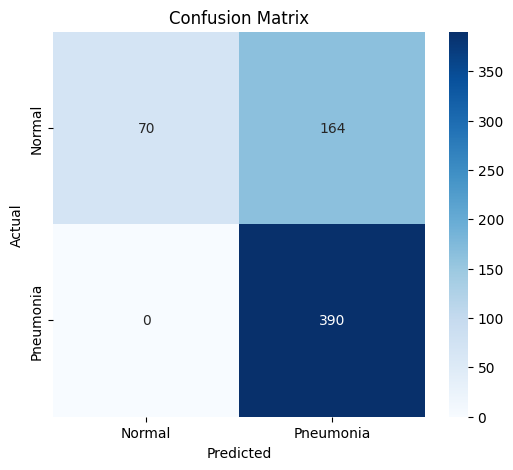

              precision    recall  f1-score   support

      Normal       1.00      0.30      0.46       234
   Pneumonia       0.70      1.00      0.83       390

    accuracy                           0.74       624
   macro avg       0.85      0.65      0.64       624
weighted avg       0.81      0.74      0.69       624



In [15]:
# Compute confusion matrix
y_true = test_set.classes

# Compute confusion matrix using evaluate()
y_pred_eval = (cnn.predict(test_set) > 0.10).astype(int).flatten()
cm = confusion_matrix(y_true, y_pred_eval)

print("Confusion Matrix:\n", cm)

# Plot confusion matrix
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Pneumonia'], yticklabels=['Normal', 'Pneumonia'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

print(classification_report(y_true, y_pred_eval, target_names=['Normal', 'Pneumonia']))

c:\repos\Computer_vision\.venv\Lib\site-packages\keras\src\models\functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(1, 64, 64, 1))']
  warnings.warn(msg)
c:\repos\Computer_vision\.venv\Lib\site-packages\keras\src\models\functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(50, 64, 64, 1))']
  warnings.warn(msg)


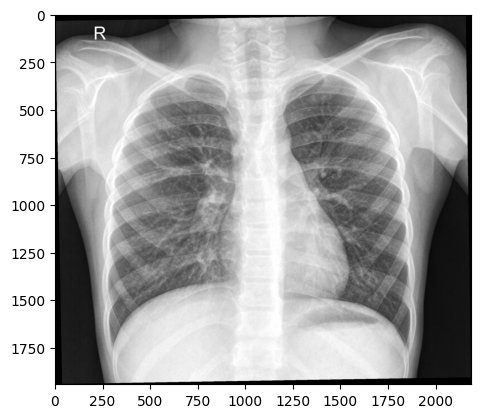

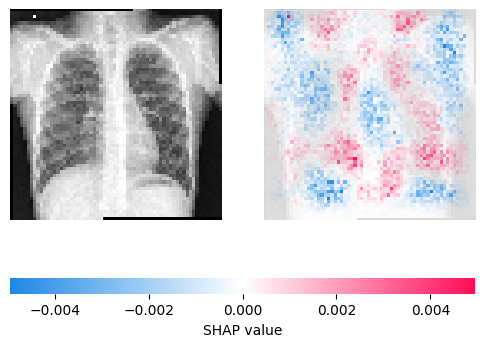

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
Prediction Probability: 0.01
Predicted Class: Normal


In [16]:
# Normal pic 
rand_norm= np.random.randint(0,len(os.listdir(train_n)))
norm_pic = os.listdir(train_n)[rand_norm]
image_path = train_n+norm_pic
load = Image.open(image_path)
img_plot = plt.imshow(load, cmap='gray') # Display the original image
img = load_img(image_path, target_size=(64,64), color_mode="grayscale")  # Resize to match model input
img_array = img_to_array(img) / 255.0  # Normalize
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
background = np.random.randn(1, 64,64, 1)  # Create background data (required for GradientExplainer)
explainer = shap.GradientExplainer(cnn, background) # Use SHAP GradientExplainer
shap_values = explainer.shap_values(img_array) # Get SHAP values for the image
shap.image_plot(shap_values, img_array) # Visualize SHAP explanations
prediction = cnn.predict(img_array)[0][0]
predicted_class = "Pneumonia" if prediction > 0.5 else "Normal" 
print(f"Prediction Probability: {prediction:.2f}")
print(f"Predicted Class: {predicted_class}")


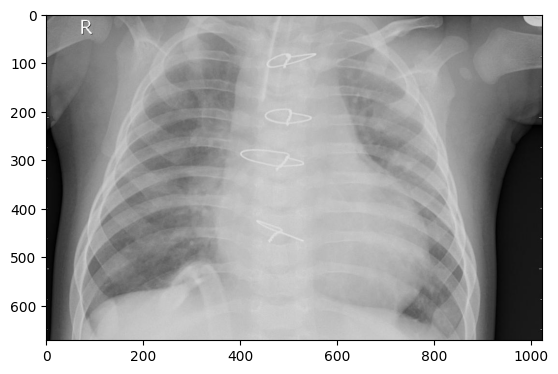

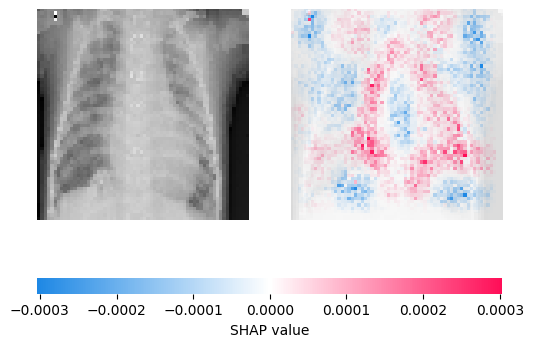

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Prediction Probability: 1.00
Predicted Class: Pneumonia


In [17]:
# Sick pic 
rand_norm= np.random.randint(0,len(os.listdir(train_p)))
norm_pic = os.listdir(train_p)[rand_norm]
image_path = train_p+norm_pic
load = load_img(image_path)
img_plot = plt.imshow(load, cmap='gray') # Display the original image
img = load_img(image_path, target_size=(64,64), color_mode="grayscale")  # Resize to match model input
img_array = img_to_array(img) / 255.0  # Normalize
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

background = np.random.randn(10, 64,64, 1)  # Create background data (required for GradientExplainer)
explainer = shap.GradientExplainer(cnn, background) # Use SHAP GradientExplainer
shap_values = explainer.shap_values(img_array) # Get SHAP values for the image
shap.image_plot(shap_values, img_array) # Visualize SHAP explanations
prediction = cnn.predict(img_array)[0][0]
predicted_class = "Pneumonia" if prediction > 0.5 else "Normal" 
print(f"Prediction Probability: {prediction:.2f}")
print(f"Predicted Class: {predicted_class}")

In [18]:
end_time = datetime.now()
duration = end_time - start_time
full_minutes = duration.seconds // 60  # Full minutes
remaining_seconds = duration.seconds % 60  # Remainder in seconds
print(end_time)
print(f"Duration: {full_minutes} minutes and {remaining_seconds} seconds")

2025-02-07 09:58:17.018606
Duration: 5 minutes and 1 seconds
